<h1>Mean-Variance Optimization</h1>

<h2>Introduction</h2>

Mean-Variance optimization was introduced be Markowitz in 1952 which laid the foundation of modern finance theory. <br>
The goal is to choose portfolio weights $w$ across $n$ assets to trade off **expected return** and **risk**.

There are two core problems in Mean-Variance optimization:
<ul>
<li>Minimum Variance Portfolio</li>
<li>Efficient Portfolio</li>
</ul>

<h2>1. Minimum Variance Portfolio</h2>

The Minimum-Variance Portfolio (*MVP*) is the cornerstone of modern portfolio theory. Its primary goal is to construct a portfolio of assets that achieves the **lowest possible level of risk** (volatility), *irrespective* of its **expected return**.

The Mathematical Problem is <br>
$$
\begin{aligned}
& \min_{w} & & w^\top \Sigma w \\
& \text{subject to}
& & \Sigma_{i} w_{i} = 1
\end{aligned}
$$

The object function &nbsp; $w^T \Sigma \ w$ &nbsp; is the portfolio variance. And we minimize this for a given level of exprected return. <br>
The constraint&nbsp; $1^T w = 1$ &nbsp; ensures weights sum to 1. We can add many constraints if we want, and we'll see this shorty.

This gives higher weights to:
<ul>
<li>assets with <b>low individual variance</b>, and</li>
<li>assets <b>not highly correlated</b> with the rest</li>
</ul>

I'm using **CVXPY** library of python for this problem.<br>
There are many other libraries as well, which we'll use shorly, but i want to implement the concept of *MVP* from scratch.

<h3>1.1 MVP with No Capital Allocation Limit</h3>

In [1]:
#importing libraries
import pandas as pd
import numpy as np

import yfinance as yf

import cvxpy as cp

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

I've selected *US* stocks.

In [2]:
tickers = ['AAPL', 'NVDA', 'JPM', 'AMZN', 'GOOGL', 'PG', 'XOM', 'JNJ']
start = "2016-01-01"
end  = "2024-12-30"

In [3]:
df = yf.download(tickers=tickers, start=start, end=end)['Close']
df.head()

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,NVDA,PG,XOM
Date,,,,,,,,
2016-01-04,23.753147,31.849501,37.711899,76.173630,48.868286,0.789632,59.527222,49.985344
2016-01-05,23.157913,31.689501,37.815689,76.492043,48.952782,0.802317,59.717113,50.411255
2016-01-06,22.704718,31.632500,37.706436,76.105415,48.246101,0.769141,59.139832,49.991783
2016-01-07,21.746481,30.396999,36.796211,75.218407,46.295052,0.738648,58.623329,49.191616
2016-01-08,21.861475,30.352501,36.295170,74.414841,45.258072,0.722792,57.704273,48.197838


In [4]:
#Breif Exploration of Data
print(df.shape)
df.info()

(2262, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2262 entries, 2016-01-04 to 2024-12-27
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2262 non-null   float64
 1   AMZN    2262 non-null   float64
 2   GOOGL   2262 non-null   float64
 3   JNJ     2262 non-null   float64
 4   JPM     2262 non-null   float64
 5   NVDA    2262 non-null   float64
 6   PG      2262 non-null   float64
 7   XOM     2262 non-null   float64
dtypes: float64(8)
memory usage: 159.0 KB


In [5]:
#computing log returns
ret = np.log(df/df.shift(1))

In [6]:
trading_days = 252

In [7]:
mu = ret.mean() * trading_days         #multiplied with 252 because returns are daily and we need to change them to annually
sigma = ret.cov() * trading_days

So now, I'll optimize the *MVP*. The objective function as mentioned earlier is &nbsp; $w^T \Sigma w$. &nbsp; And I'm minimizing it.<br>
There will be **no short selling**. So, I'm selecting the following constraints:
$$
\begin{aligned}
\Sigma_{i} w_{i} = 1, \\
w \ge 0
\end{aligned}
$$

In [8]:
#optimization
n = len(tickers)
w = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(w, sigma.values))
constraint = [cp.sum(w) == 1, w >= 0]
prob = cp.Problem(objective, constraint)
prob.solve()

np.float64(0.022956416643531707)

The *portfolio expected return* is:
$$
R_{P} = w^T \mu
$$
and, The *portfolio volatility* is:
$$
\sigma_{P} = \sqrt{w^T \Sigma w}
$$

In [9]:
#Results
w_opt = np.array(w.value).flatten()
w_opt = pd.Series(w_opt, index=tickers)
port_mean = mu.values @ w_opt
port_vol = np.sqrt(w_opt.T @ sigma.values @ w_opt)
print("Optimal Weights (No Short Selling):")
print(w_opt.round(4))
print("Expected Annual Return:", round(port_mean, 4))
print("Expected Annual Volatility:", round(port_vol, 4))

Optimal Weights (No Short Selling):
AAPL    -0.0000
NVDA     0.0885
JPM      0.0334
AMZN     0.3806
GOOGL    0.0136
PG       0.0000
XOM      0.3635
JNJ      0.1203
dtype: float64
Expected Annual Return: 0.1047
Expected Annual Volatility: 0.1515


Results suggests that, portfoli based on these weights will have *expected return* of **10.4%** at the *risk* of **15%**.

<h3>1.2 MVP with Capital Allocation Limit of 15%</h3>

Now I'll implement *capital allocation limit* of **15%** .<br>
Everything will be same except a little change in the second constraint, which will be:<br>
$$
0 \le w \le 0.15
$$

In [10]:
#optimization
n = len(tickers)
w1 = cp.Variable(n)
objective1 = cp.Minimize(cp.quad_form(w1, sigma.values))
constraint1 = [cp.sum(w1) == 1, w1 >= 0, w1 <= 0.15]
prob1 = cp.Problem(objective1, constraint1)
prob1.solve()

np.float64(0.031283850059520155)

In [11]:
#Results
w_opt1 = np.array(w1.value).flatten()
w_opt1 = pd.Series(w_opt1, index=tickers)
port_mean1 = mu.values @ w_opt1
port_vol1 = np.sqrt(w_opt1.T @ sigma.values @ w_opt1)
print("Optimal Weights (15% Cap):")
print(w_opt1.round(4))
print("Expected Annual Return:", round(port_mean1, 4))
print("Expected Annual Volatility:", round(port_vol1, 4))

Optimal Weights (15% Cap):
AAPL     0.1310
NVDA     0.1223
JPM      0.1468
AMZN     0.1500
GOOGL    0.1500
PG      -0.0000
XOM      0.1500
JNJ      0.1500
dtype: float64
Expected Annual Return: 0.1535
Expected Annual Volatility: 0.1769


Results suggests that, portfolio based on these weights will have *expected return* of **15.3%** at the *risk* of **17.6%**.

We can see a little improvement in the risk-return trade-off between both portfolios.

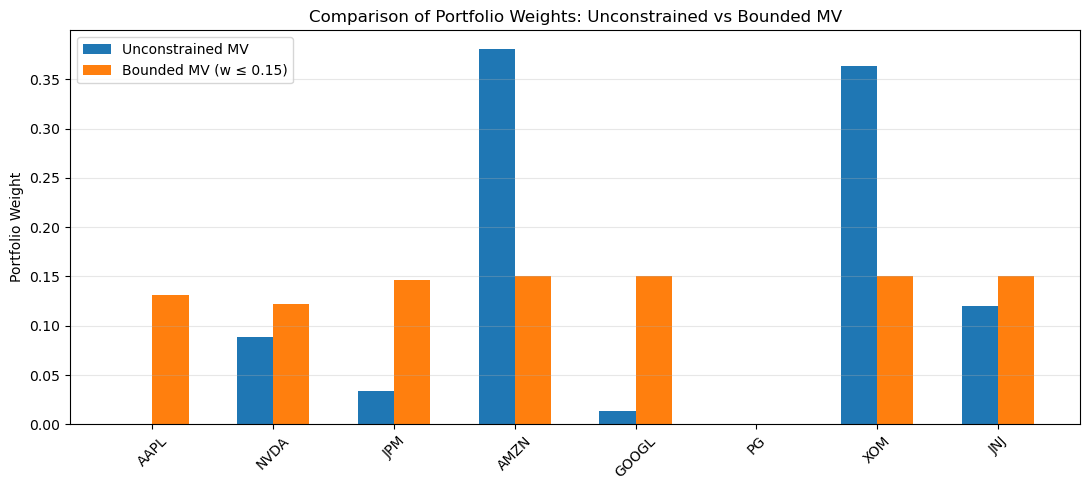

In [12]:
#plotting the weights bar chart of both portfolios
# Convert Series to aligned numpy arrays
w_uncon = w_opt.values
w_bound = w_opt1.values

x = np.arange(len(tickers))
width = 0.3  # width of bars

plt.figure(figsize=(11, 5))

# Plot bars
plt.bar(x - width/2, w_uncon, width, label='Unconstrained MV')
plt.bar(x + width/2, w_bound, width, label='Bounded MV (w ≤ 0.15)')

# Add labels
plt.xticks(x, tickers, rotation=45)
plt.ylabel("Portfolio Weight")
plt.title("Comparison of Portfolio Weights: Unconstrained vs Bounded MV")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

plt.savefig('Comparison_of_Portfolio_Weights.jpg');

<h2>2. Efficient Portfolio</h2>

An **Efficient Portfolio** is one that offers the higgest possible expected return for a given level of risk. These portfolios considered *optimal* because no other portfolio provides a better risk-return trade-off. Such efficient portfolios form an **efficient frontier**, a central concept in modern
finance theory.

There are two way to solve this problem:
<ul>
<li>Minimizing the Risk</li>
<li>Maximizing the Return</li>
</ul>

I'm selecting the second one, **Maximizing the Return**.<br> The objective function becomes finding the portfolio with *maximum return* for a *given level of risk*.

Mathematically this problem is:
$$
\begin{aligned}
&\max_{w} & & \mu^T w \\
&subject \ to & & w^T \Sigma w \le \sigma^2_{target} \ , \\
& & & \Sigma_{i} \ w_{i} = 1
\end{aligned}
$$

For this problem, I'm using a more efficient and robust library of python, **PyPortfolioOpt**. This library is build up on *CVXPY* and it also uses Capital Allocation Line.

In [13]:
from pypfopt import expected_returns, risk_models, efficient_frontier, plotting

Using the above dataframe of prices

In [14]:
df.head()

Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,NVDA,PG,XOM
Date,,,,,,,,
2016-01-04,23.753147,31.849501,37.711899,76.173630,48.868286,0.789632,59.527222,49.985344
2016-01-05,23.157913,31.689501,37.815689,76.492043,48.952782,0.802317,59.717113,50.411255
2016-01-06,22.704718,31.632500,37.706436,76.105415,48.246101,0.769141,59.139832,49.991783
2016-01-07,21.746481,30.396999,36.796211,75.218407,46.295052,0.738648,58.623329,49.191616
2016-01-08,21.861475,30.352501,36.295170,74.414841,45.258072,0.722792,57.704273,48.197838


In [15]:
mu = expected_returns.mean_historical_return(df, compounding=False)  #computing arithmetic returns
sigma = risk_models.sample_cov(df)

In [16]:
#compute Minimum volatility
ef = efficient_frontier.EfficientFrontier(mu, sigma)
ef.min_volatility()
ret_min, vol_min, _ = ef.portfolio_performance()
print("Minimum Attainable Volatility is:", vol_min)

Minimum Attainable Volatility is: 0.15141945174583749


So now, I've to choose a target volatility for with my maximum return optimization problem will be computed. As the minimum attainable volatility has be computed, I can use that as my target volatility. I'll add a bit of jitter to the target volatility so that my optimization porblem does run to any error.<br>
Minimum attainable volatitlity also means that, the volatility at which the *Efficient Frontier starts*.

In [17]:
target_vol = vol_min + 1e-03     #adding a bit jitter

In [18]:
ef_opt = efficient_frontier.EfficientFrontier(mu, sigma)
ef_opt.efficient_risk(target_vol)

ret_opt, vol_opt, _ = ef_opt.portfolio_performance()
weight_opt = ef_opt.clean_weights()
weight_opt = pd.Series(weight_opt)
print("Optimal Weights:\n",weight_opt)

Optimal Weights:
 AAPL     0.01687
AMZN     0.09401
GOOGL    0.02515
JNJ      0.34411
JPM      0.03112
NVDA     0.01635
PG       0.36338
XOM      0.10900
dtype: float64


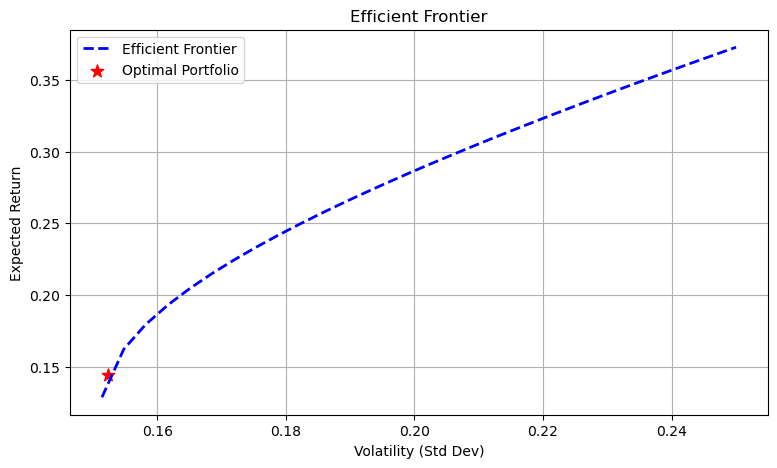

In [19]:
# Choose several volatility values from min-vol to some upper range
vol_points = np.linspace(vol_min, 0.25, 30)   # 0.25 means 25%, adjust if needed

frontier_vols = []
frontier_rets = []

for v in vol_points:
    ef_temp = efficient_frontier.EfficientFrontier(mu, sigma)
    try:
        ef_temp.efficient_risk(v)
        r, s, _ = ef_temp.portfolio_performance(verbose=False)
        frontier_vols.append(s)
        frontier_rets.append(r)
    except:
        # skip infeasible target vols
        continue

#Plot efficient frontier + optimal portfolio

plt.figure(figsize=(9,5))

# Frontier curve
plt.plot(frontier_vols, frontier_rets, "b--", linewidth=2, label="Efficient Frontier")

# Your optimal target-vol portfolio
plt.scatter(vol_opt, ret_opt, c="red", s=90, marker="*", label="Optimal Portfolio")

plt.title("Efficient Frontier")
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.legend()

plt.savefig('Efficient_Frontier.jpg');

As I've selected the minimum attainable volatility as the target volatility, it's clearly visible that the optimal portfolio is at the start of the Efficient Frontier.